### Step 1: Setup & Imports

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

###Step 2: Get Images from Internet

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO

In [ ]:
def download_images(image_urls, save_dir):
  os.makedirs(save_dir, exist_ok = True)
  for i, url in enumerate(image_urls):
    try:
      response = requests.get(url, timeout = 5)
      img = Image.open(BytesIO(response.content)).convert('RGB')
      img.save(os.path.join(save_dir, f"img_{i}.jpg"))
    except Exception as e:
      print(f"Failed to Download {url}: {e}")

In [ ]:
car_urls = [
    'https://stimg.cardekho.com/images/carexteriorimages/630x420/Jaguar/F-Pace/10644/1755774688332/front-left-side-47.jpg?impolicy=resize&imwidth=480',
    'https://img.autocarindia.com/ExtraImages/20241205062334_20240606032223_Creta%20showroom%20shot%20_1_.jpg',
    'https://cdni.autocarindia.com/Features/_New%20Sedans%20%20Sports%20Cars%20Web%20Resized%20%20Watermarked._008.jpeg',
    'https://a.storyblok.com/f/197805/7a2484c876/how-to-create-a-car-newblogcover.png',
    'https://kidsroar.in/cdn/shop/files/8989898_ff5f50c0-0de9-45c8-b9fb-61c8aa0ef070_800x.jpg?v=1692355576'
            ]

truck_urls = [
    'https://www.tatamotors.com/wp-content/uploads/2023/10/press-13sep23-01.jpg',
    'https://plus.unsplash.com/premium_photo-1664695368767-c42483a0bda1?fm=jpg&q=60&w=3000&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8dHJ1Y2t8ZW58MHx8MHx8fDA%3D',
    'https://www.macktrucks.com/trucks/media_1818f3d88d2375704ad949bbd5f4d34ec2039895f.png?width=750&format=png&optimize=medium',
    'https://5.imimg.com/data5/MW/JN/FM/SELLER-89031277/10-chakka-for-sale-in-indore-1000x1000.png',
    'https://fordtrucksglobal.com/Uploads/Page/technologies_05.jpg'
 ]
ute_urls = [
    'https://www.chevrolet.com/content/dam/chevrolet/na/us/english/vdc-collections/2025/trucks/colorado/nav/2025-colorado-4zr-gal-driver-front-3quarter-nav.jpg?imwidth=960',
    'https://imgd.aeplcdn.com/1280x720/n/cw/ec/191395/kia-left-front-three-quarter1.jpeg?isig=0',
    'https://autoimage.capitalone.com/cms/Auto/assets/images/3403-hero-2024-chevrolet-silverado-hd-zr2.jpg',
    'https://www.topgear.com/sites/default/files/news-listicle/image/2023/11/TRUCKSLEAD.jpg',
    'https://static01.nytimes.com/newsgraphics/2023-02-14-big-evs/a09067a7b772d4328be9141db7df9f91b33c0e04/_assets/cars-rivian-rivian.jpg'
]

download_images(car_urls, 'data/cars')
download_images(truck_urls, 'data/trucks')
download_images(ute_urls, 'data/utes')

### Step 3: Build TensorFlow Dataset

In [ ]:
batch_size = 32
image_size = (128,128)

train_ds = tf.keras.utils.image_dataset_from_directory(
    'data',
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = image_size,
    batch_size = batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'data',
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = image_size,
    batch_size = batch_size
)

# Get class names before prefetching
class_names = train_ds.class_names


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)

Found 15 files belonging to 3 classes.
Using 12 files for training.
Found 15 files belonging to 3 classes.
Using 3 files for validation.


In [ ]:
#How did validation data automatically picked only 3 files?

### Step 4: Transfer Learning (Using MobileNetV2 from TF Hub)

In [ ]:
feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    input_shape = (224, 224, 3),
    trainable=False
)

class CustomModel(tf.keras.Model):
    def __init__(self, feature_extractor, num_classes):
        super(CustomModel, self).__init__()
        self.resizing = tf.keras.layers.Resizing(224, 224)
        self.feature_extractor = feature_extractor
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.resizing(inputs)
        x = self.feature_extractor(x)
        return self.classifier(x)

model = CustomModel(feature_extractor, num_classes=3)

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(train_ds, validation_data = val_ds, epochs = 5)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.2500 - loss: 1.6081 - val_accuracy: 0.3333 - val_loss: 1.3087
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step - accuracy: 0.3333 - loss: 1.2967 - val_accuracy: 0.3333 - val_loss: 1.3177
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step - accuracy: 0.4167 - loss: 1.1172 - val_accuracy: 0.6667 - val_loss: 1.3678
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - accuracy: 0.5000 - loss: 1.0125 - val_accuracy: 0.3333 - val_loss: 1.4435
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - accuracy: 0.5000 - loss: 0.9519 - val_accuracy: 0.3333 - val_loss: 1.5170


### Step 5: Evaluate & Predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.3333 - loss: 1.5170
Accuracy:0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


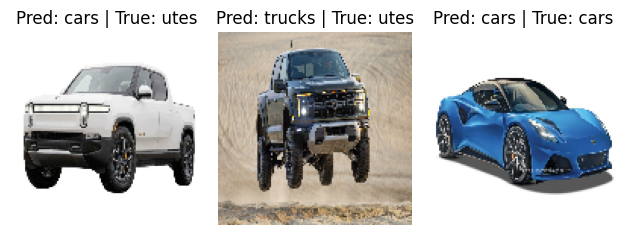

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Accuracy:{acc:.2f}")

# Use the class_names variable obtained before prefetching
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    for i in range(3): # Changed range to 3 as there are only 3 validation images
        ax = plt.subplot(1, 3, i + 1) # Adjusted subplot layout for 3 images
        plt.imshow(images[i].numpy().astype("uint8"))
        # Assuming you want to display the predicted and true labels as well
        predicted_class = class_names[tf.argmax(preds[i])]
        true_class = class_names[labels[i]]
        plt.title(f"Pred: {predicted_class} | True: {true_class}")
        plt.axis("off")

plt.tight_layout()
plt.show()

### Step 6: Collect Predictions & True Labels

In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
  preds = model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


### Step 7: Compute Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1 0 0]
 [0 0 0]
 [1 1 0]]


In [ ]:
print('Classification Matrix:')
classification_report(y_true, y_pred, target_names = class_names)

Classification Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

'              precision    recall  f1-score   support\n\n        cars       0.50      1.00      0.67         1\n      trucks       0.00      0.00      0.00         0\n        utes       0.00      0.00      0.00         2\n\n    accuracy                           0.33         3\n   macro avg       0.17      0.33      0.22         3\nweighted avg       0.17      0.33      0.22         3\n'

### Step 8: Plot the Confusion Matrix

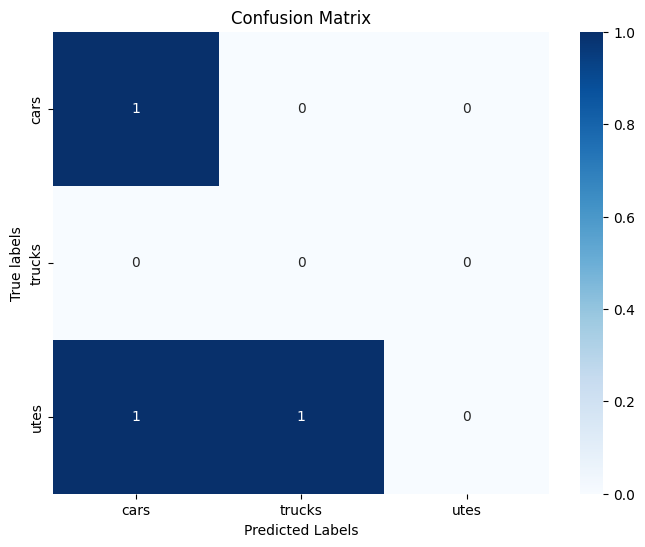

In [ ]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


/tmp/ipython-input-2434452053.py:1: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]


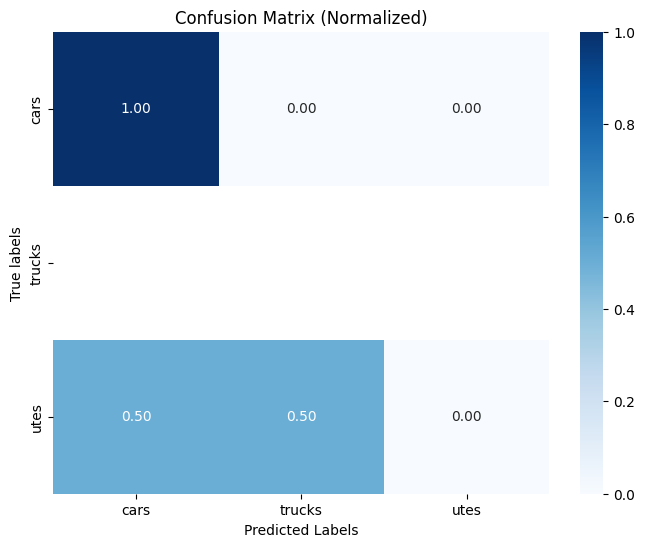

In [ ]:
cm_normalized = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
plt.figure(figsize = (8,6))
sns.heatmap(cm_normalized, annot = True, fmt = '.2f', cmap = 'Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)

for cls, acc in zip(class_names, class_accuracies):
    print(f"{cls}: {acc:.2%}")


cars: 100.00%
trucks: nan%
utes: 0.00%


/tmp/ipython-input-2994126974.py:1: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


/tmp/ipython-input-329963336.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_accuracies, palette="Blues_d")


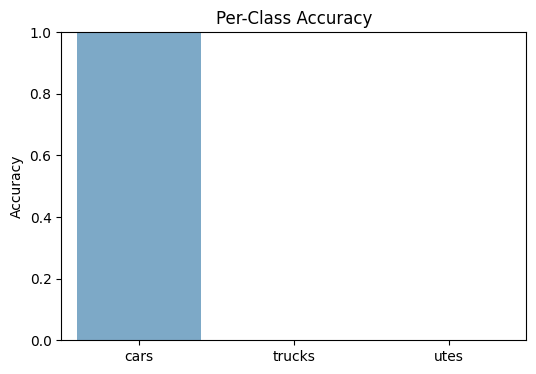

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=class_names, y=class_accuracies, palette="Blues_d")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.show()
